# DEtection TRansformer for RBC Detection 
 



In [ ]:
!pip install -q pytorch-lightning

In [ ]:
!pip install -q transformers timm

In [3]:
!nvidia-smi

Thu Jun  8 16:44:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

In [5]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

import torchvision
import os

from PIL import Image, ImageDraw

import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

# Data pre-processing

In [6]:
!mkdir data

In [7]:
!cp -r '/content/drive/MyDrive/DDP_Data/RBC_Kaggle_data' data/

In [9]:
train_df = pd.read_csv('/content/data/RBC_Kaggle_data/train_annotations.csv')

In [10]:
val_df = pd.read_csv('/content/data/RBC_Kaggle_data/val_annotations.csv')

In [11]:
# Convert the train- annotations.csv to annotations.json

path = '/content/data/RBC_Kaggle_data/train_annotations.csv' # the path to the CSV file
save_json_path = '/content/data/train_annotations.json'

data = pd.read_csv(path)

images = []
categories = []
annotations = []

category = {}
category["supercategory"] = 'None'
category["id"] = 0
category["name"] = 'None'
categories.append(category)

data['fileid'] = data['filename'].astype('category').cat.codes
data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
data['categoryid'] = data['categoryid']+1
data['annid'] = data.index

def image(row):
    image = {}
    image["height"] = row.height
    image["width"] = row.width
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

def category(row):
    category = {}
    category["supercategory"] = 'None'
    category["id"] = row.categoryid
    category["name"] = row[1]
    return category

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

for row in data.itertuples():
    annotations.append(annotation(row))

imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    images.append(image(row))

catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
for row in catdf.itertuples():
    categories.append(category(row))

data_coco = {}
data_coco["images"] = images
data_coco["categories"] = categories
data_coco["annotations"] = annotations
json.dump(data_coco, open(save_json_path, "w"), indent=4)

In [12]:
a = json.load(open('/content/data/train_annotations.json'))

In [13]:
# Convert the train- annotations.csv to annotations.json

path = '/content/data/RBC_Kaggle_data/val_annotations.csv' # the path to the CSV file
save_json_path = '/content/data/val_annotations.json'

data = pd.read_csv(path)

images = []
categories = []
annotations = []

category = {}
category["supercategory"] = 'None'
category["id"] = 0
category["name"] = 'None'
categories.append(category)

data['fileid'] = data['filename'].astype('category').cat.codes
data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
data['categoryid'] = data['categoryid']+1
data['annid'] = data.index

def image(row):
    image = {}
    image["height"] = row.height
    image["width"] = row.width
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

def category(row):
    category = {}
    category["supercategory"] = 'None'
    category["id"] = row.categoryid
    category["name"] = row[1]
    return category

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

for row in data.itertuples():
    annotations.append(annotation(row))

imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    images.append(image(row))

catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
for row in catdf.itertuples():
    categories.append(category(row))

data_coco = {}
data_coco["images"] = images
data_coco["categories"] = categories
data_coco["annotations"] = annotations
json.dump(data_coco, open(save_json_path, "w"), indent=4)

In [14]:
b = json.load(open('/content/data/val_annotations.json'))

# Dataloader

In [15]:
class CocoDetection(torchvision.datasets.CocoDetection):
  '''
    Custom DataLoader class for COCO dataset.

    Args:
    - img_folder (str): Path to the folder containing the COCO dataset images.
    - feature_extractor (object): The feature extractor used for preprocessing images and targets.
    - train (bool, optional): Specifies whether the DataLoader is for training or validation. Default is True (training).

    Attributes:
    - ann_file (str): Path to the annotation file corresponding to the specified train/validation split.
    - feature_extractor (object): The feature extractor used for preprocessing images and targets.

    Methods:
    - __init__(self, img_folder, feature_extractor, train=True): Initializes the CocoDetection class.
    - __getitem__(self, idx): Retrieves a specific image and its target at the given index.

    Returns:
    - pixel_values (tensor): Preprocessed image tensor.
    - target (tensor): Preprocessed target tensor.
  '''

  def __init__(self, img_folder, feature_extractor, train=True):
      ann_file = os.path.join(img_folder, "/content/data/train_annotations.json" if train else "/content/data/val_annotations.json")
      super(CocoDetection, self).__init__(img_folder, ann_file)
      self.feature_extractor = feature_extractor

  def __getitem__(self, idx):
      # read in PIL image and target in COCO format
      img, target = super(CocoDetection, self).__getitem__(idx)
      
      # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
      image_id = self.ids[idx]
      target = {'image_id': image_id, 'annotations': target}
      encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
      pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
      target = encoding["labels"][0] # remove batch dimension

      return pixel_values, target

In [17]:
# importing DETR deature extractor from Hugging Face
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='/content/data/RBC_Kaggle_data/train_images', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder='/content/data/RBC_Kaggle_data/val_images', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [18]:
print("Number of training examples = ", len(train_dataset))
print("Number of validation examples = ", len(val_dataset))

Number of training examples =  77
Number of validation examples =  23


Training image example

Image n°18


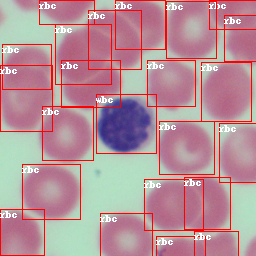

In [19]:
# visualising training image with annotations

image_ids = train_dataset.coco.getImgIds()

# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/data/RBC_Kaggle_data/train_images', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), str(id2label[class_idx]), fill='white')

image

PyTorch Dataloader

In [20]:
from torch.utils.data import DataLoader

# Function to collate and preprocess a batch of data for DataLoader
def collate_fn(batch):
  '''
    Collates and preprocesses a batch of data for DataLoader.

    Args:
    - batch (list): List of data items, each containing an image and its corresponding label.

    Returns:
    - batch (dict): Dictionary containing the preprocessed batch data, with keys:
        - 'pixel_values': Tensor of preprocessed image pixel values.
        - 'pixel_mask': Tensor representing the mask for the preprocessed image.
        - 'labels': List of preprocessed labels.
  '''
  
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {} # 3 keys - pixel_values; pixel_mask; labels
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels

  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))


This method is deprecated and will be removed in v4.27.0. Please use pad instead.


In [21]:
pixel_values, target = train_dataset[0]

In [22]:
pixel_values.shape # shape after necessary padding in line with the DETR algorithm

torch.Size([3, 800, 800])

# Training with PyTorch Lightning

In [23]:
class DETR(pl.LightningModule):

  '''
    Custom DataLoader class for COCO dataset.

    Args:
    - img_folder (str): Path to the folder containing the COCO dataset images.
    - feature_extractor (object): The feature extractor used for preprocessing images and targets.
    - train (bool, optional): Specifies whether the DataLoader is for training or validation. Default is True (training).

    Attributes:
    - ann_file (str): Path to the annotation file corresponding to the specified train/validation split.
    - feature_extractor (object): The feature extractor used for preprocessing images and targets.

    Methods:
    - __init__(self, img_folder, feature_extractor, train=True): Initializes the CocoDetection class.
    - __getitem__(self, idx): Retrieves a specific image and its target at the given index.

    Returns:
    - pixel_values (tensor): Preprocessed image tensor.
    - target (tensor): Preprocessed target tensor.
  '''

  def __init__(self, lr, lr_backbone, weight_decay):
    super().__init__()
    # replace COCO classification head with custom head
    self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                        num_labels=len(id2label),
                                                        ignore_mismatched_sizes=True)
    # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
    self.lr = lr
    self.lr_backbone = lr_backbone
    self.weight_decay = weight_decay

  def forward(self, pixel_values, pixel_mask):
    outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    return outputs

  def common_step(self, batch, batch_idx):
    pixel_values = batch["pixel_values"]
    pixel_mask = batch["pixel_mask"]
    labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

    outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

    loss = outputs.loss
    loss_dict = outputs.loss_dict

    return loss, loss_dict

  def training_step(self, batch, batch_idx):
    loss, loss_dict = self.common_step(batch, batch_idx)     
    # logs metrics for each training_step,
    # and the average across the epoch
    self.log("training_loss", loss)
    for k,v in loss_dict.items():
      self.log("train_" + k, v.item())

    return loss

  def validation_step(self, batch, batch_idx):
    loss, loss_dict = self.common_step(batch, batch_idx)     
    self.log("validation_loss", loss)
    for k,v in loss_dict.items():
      self.log("validation_" + k, v.item())

    return loss

  def configure_optimizers(self):
    param_dicts = [
          {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
          {
              "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
              "lr": self.lr_backbone,
          },
    ]
    optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                              weight_decay=self.weight_decay)
    
    return optimizer

  def train_dataloader(self):
    return train_dataloader

  def val_dataloader(self):
        return val_dataloader

In [24]:
#creating model instance
model = DETR(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4) 
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from pytorch_lightning import Trainer

trainer = Trainer( max_steps=300, gradient_clip_val=0.1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [28]:
#training the model
trainer.fit(model) 

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.039   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=300` reached.


In [30]:
# save your model
torch.save(model.state_dict(), '/content/data/model.pth')

# Evaluating the model

In [ ]:
! git clone https://github.com/facebookresearch/detr.git
%cd /content/detr

In [ ]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

# Visualisation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[5]

In [ ]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 800])


In [ ]:
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

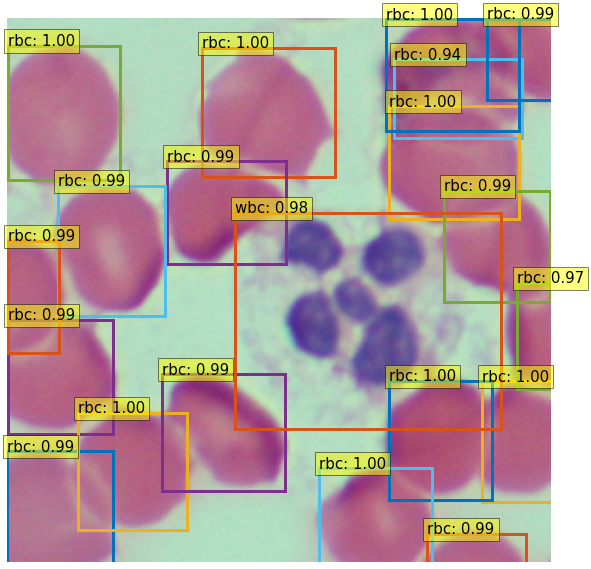

In [ ]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/data/val_images', image['file_name']))

visualize_predictions(image, outputs)